[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kdlamb/SP2-VAE/blob/main/SP2_PCA.ipynb)

## SP2 PCA Analysis
This notebook uses PCA from the sci-kit learn library to analyze signals from the Single Particle Soot Photometer. Here we apply PCA to the scattering and incandescent channels from the NOAA SP2.

## Download the L-II signal data
You can download the NOAA SP2 data directly from the [Zenodo repository](https://zenodo.org/records/15800436) by uncommenting and running the following code (can be slow). Alternatively, you can first download the data directly to your computer and then upload the files to Colab.

In [1]:
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_train.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_train.npy"
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_val.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_val.npy"
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_test.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_test.npy"

## Install packages and load in libraries

In [2]:
import os
import math
import numpy as np
import seaborn as sns
import pandas as pd
import time
import random

import torch

from torch.nn import Conv1d, ConvTranspose1d
from torch.nn import Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
# for reproducibility
np.random.seed(0)
torch.manual_seed(0)

## Preprocess SP2 Data Sets

In [38]:
X_train = np.load("Lab_X_train.npy")
Y_train = np.load("Lab_Y_train.npy")

X_val = np.load("Lab_X_val.npy")
Y_val = np.load("Lab_Y_val.npy")

X_test = np.load("Lab_X_test.npy")
Y_test = np.load("Lab_Y_test.npy")

In [39]:
import numpy as np

unique_classes_orig, class_counts_orig = np.unique(Y_train, return_counts=True)

mask = np.any(X_train[:, :, 1] > 0.2, axis=1)
X_train_filtered = X_train[mask]
Y_train_filtered = Y_train[mask]

unique_classes_after, class_counts_after = np.unique(Y_train_filtered, return_counts=True)

print("Different aerosol classes detectable incandesence:")
for cls in unique_classes_orig:
    count_orig = class_counts_orig[unique_classes_orig == cls][0]
    count_after = class_counts_after[unique_classes_after == cls][0] if cls in unique_classes_after else 0
    percentage_change = (count_after / count_orig) * 100 if count_orig > 0 else 0
    print(f"Class {cls}: Before = {count_orig}, After = {count_after}, Percentage = {percentage_change:.2f}%")

Different aerosol classes detectable incandesence:
Class 0.0: Before = 20004, After = 19660, Percentage = 98.28%
Class 1.0: Before = 20018, After = 16223, Percentage = 81.04%
Class 2.0: Before = 20009, After = 1706, Percentage = 8.53%
Class 3.0: Before = 20001, After = 4786, Percentage = 23.93%
Class 4.0: Before = 20005, After = 5402, Percentage = 27.00%
Class 5.0: Before = 20008, After = 18377, Percentage = 91.85%
Class 6.0: Before = 20037, After = 19678, Percentage = 98.21%


In [40]:
# APPLY INCANDESCENT THRESHOLD
mask = np.any(X_train[:, :, 1] > 0.2, axis=1)
X_train = X_train[mask]
Y_train = Y_train[mask]

# APPLY INCANDESCENT THRESHOLD
mask_val = np.any(X_val[:, :, 1] > 0.2, axis=1)
X_val = X_val[mask_val]
Y_val = Y_val[mask_val]

# APPLY INCANDESCENT THRESHOLD
mask_test = np.any(X_test[:, :, 1] > 0.2, axis=1)
X_test = X_test[mask_test]
Y_test = Y_test[mask_test]

In [41]:
def get_features(Xdata):
  # proprocess data from the SP2 
  # get typical features used in analysis (color ratio, peak heights)
  # normalize data for each channel

  X_min = np.min(Xdata,axis=1)
  X_max = np.max(Xdata,axis=1)
  # Calculate the color ratio
  color_ratio = X_max[:,1] / X_max[:,2]

  X_norm = (Xdata-np.repeat(X_min[:,np.newaxis,:],400,axis=1))
  X_norm/=(np.repeat(X_max[:,np.newaxis,:],400,axis=1)-np.repeat(X_min[:,np.newaxis,:],400,axis=1))

  return X_norm,color_ratio,X_min,X_max

In [42]:
X_train,color_channel_ratio,channel_min_X_train,channel_max_X_train = get_features(X_train)
X_val,color_channel_ratio_val,channel_min_X_val,channel_max_X_val = get_features(X_val)
X_test,color_channel_ratio_test,channel_min_test,channel_max_X_test = get_features(X_test)

Text(0.5, 1.0, 'Ch. 3')

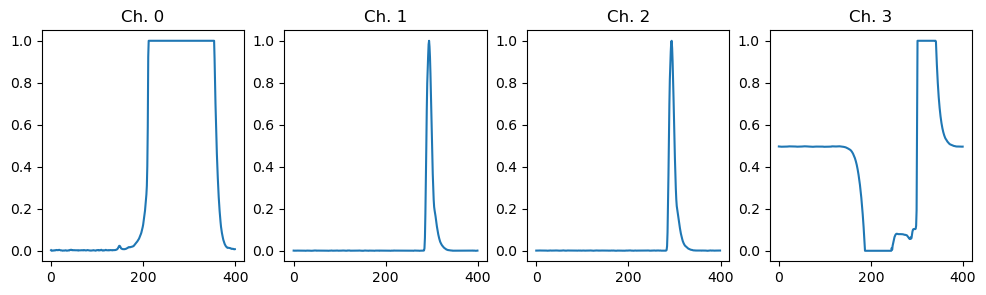

In [45]:
n = random.randint(1, X_train.shape[0])
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(X_train[n,:,0])
axes[0].set_title("Ch. 0")
axes[1].plot(X_train[n,:,1])
axes[1].set_title("Ch. 1")
axes[2].plot(X_train[n,:,2])
axes[2].set_title("Ch. 2")
axes[3].plot(X_train[n,:,3])
axes[3].set_title("Ch. 3")

## Apply PCA to Ch. 0 and Ch. 1

In [10]:
pca_ch0 = PCA()
pca_ch0.fit(X_train[:,:, 0])

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [11]:
cumsum = np.cumsum(pca_ch0.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 
print(d)

11


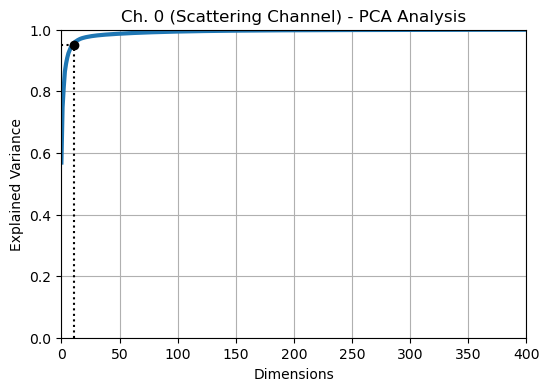

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.title("Ch. 0 (Scattering Channel) - PCA Analysis")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.grid(True)

plt.show()

In [13]:
pca_ch1 = PCA()
pca_ch1.fit(X_train[:,:, 1])

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [14]:
cumsum = np.cumsum(pca_ch1.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 
print(d)

18


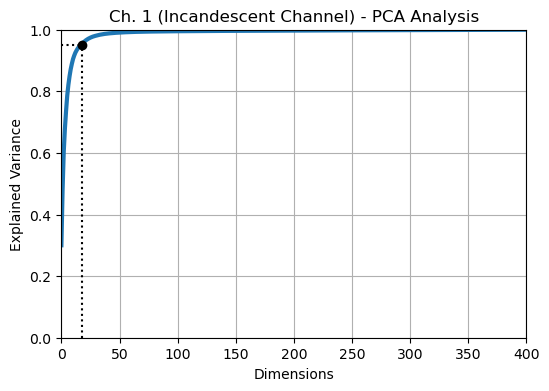

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.title("Ch. 1 (Incandescent Channel) - PCA Analysis")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.grid(True)

plt.show()

In [16]:
PCA_Ch0 = pca_ch0.transform(X_train[:,:, 0])
PCA_Ch1 = pca_ch1.transform(X_train[:,:, 1])

In [17]:
pca_ch0.explained_variance_ratio_[0:6]

array([0.56868213, 0.17935585, 0.06464655, 0.05178803, 0.02522957,
       0.01866197])

In [18]:
pca_ch1.explained_variance_ratio_[0:9]

array([0.30015214, 0.17697508, 0.12590788, 0.0749493 , 0.057867  ,
       0.049825  , 0.03528147, 0.02778317, 0.02303533])

In [19]:
pca_ch0.components_.shape

(400, 400)

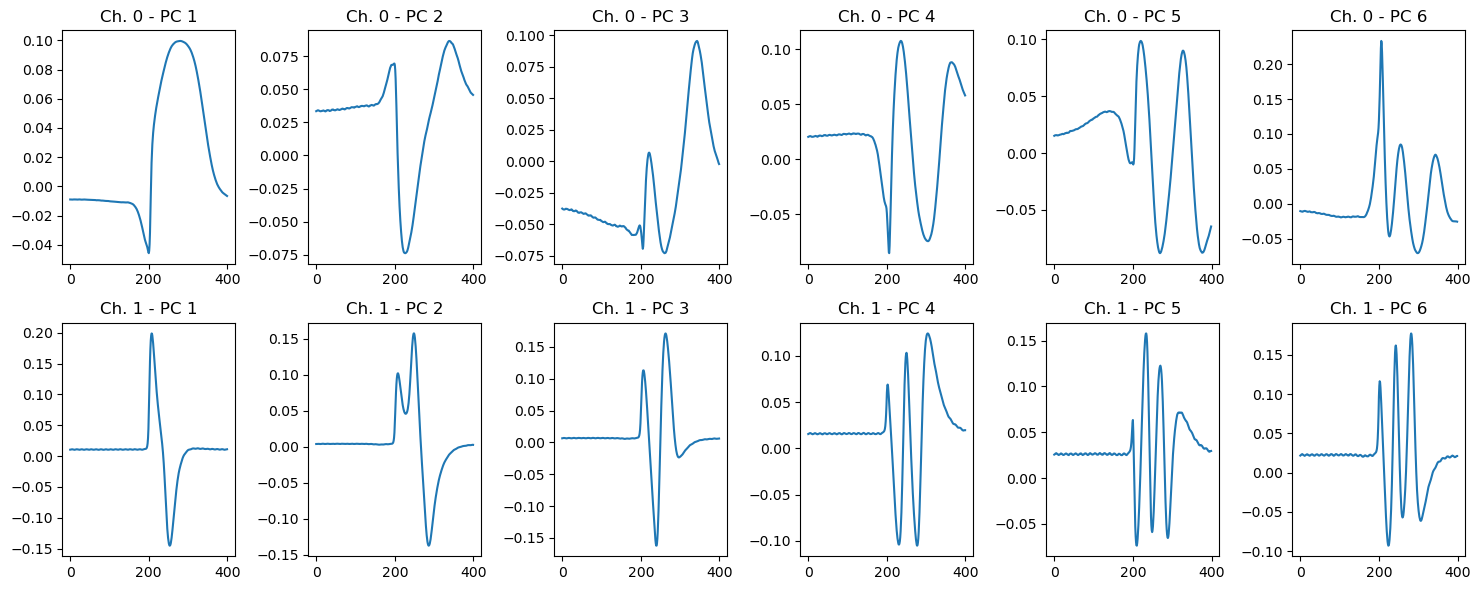

In [20]:
## Plot components 
num_components_to_plot = 6

fig, axes = plt.subplots(2, num_components_to_plot,figsize=(15,6))

for i in range(0,6):
    components = pca_ch0.components_[i,:]
    ax = axes[0,i]
    ax.plot(components)
    ax.set_title(f'Ch. 0 - PC {i+1}')
    
for i in range(0,6):
    components = pca_ch1.components_[i,:]
    ax = axes[1,i]
    ax.plot(components)
    ax.set_title(f'Ch. 1 - PC {i+1}')
    
plt.tight_layout()
plt.savefig("PC_Ch0Ch1.png")
plt.show()

In [21]:
## Reconstruct signals from components (including up to 95% variance in original signals)

In [22]:
pca_ch0 = PCA(n_components=0.95)
Ch0_reduced = pca_ch0.fit_transform(X_train[:,:,0])

In [37]:
Ch0_reduced.shape

(85832, 11)

In [23]:
Ch0_recovered = pca_ch0.inverse_transform(Ch0_reduced)

In [24]:
pca_ch1 = PCA(n_components=0.95)
Ch1_reduced = pca_ch1.fit_transform(X_train[:,:,1])

In [25]:
Ch1_recovered = pca_ch1.inverse_transform(Ch1_reduced)

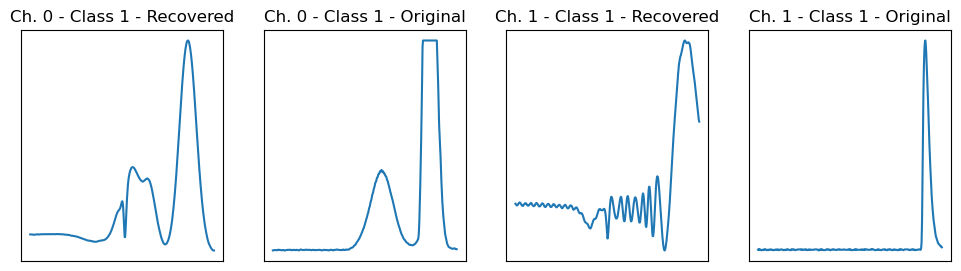

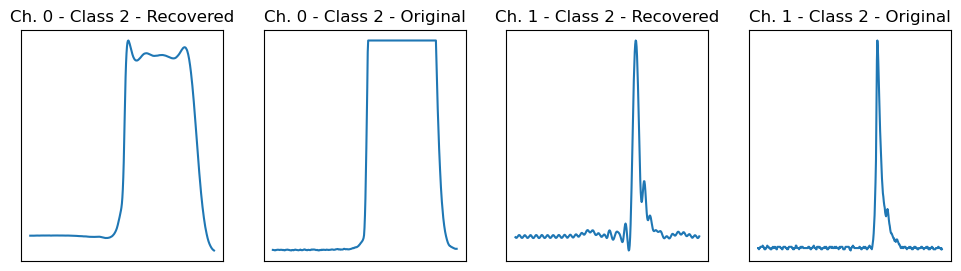

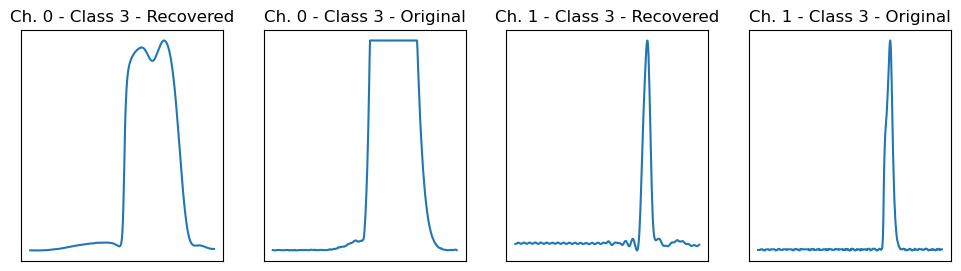

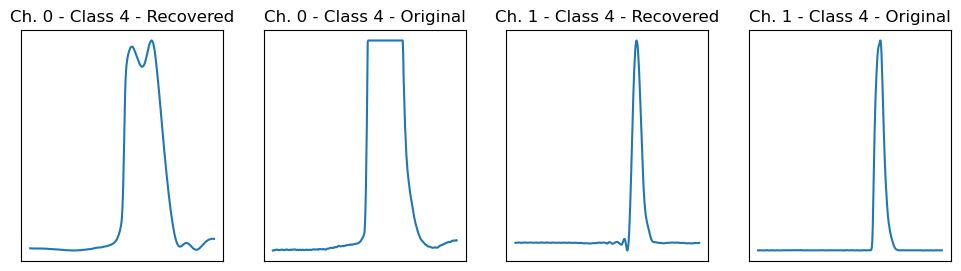

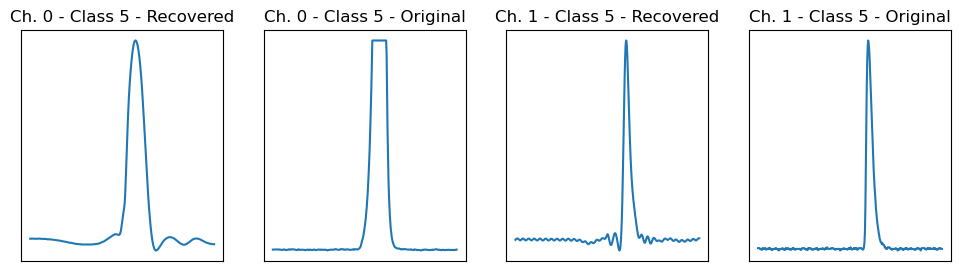

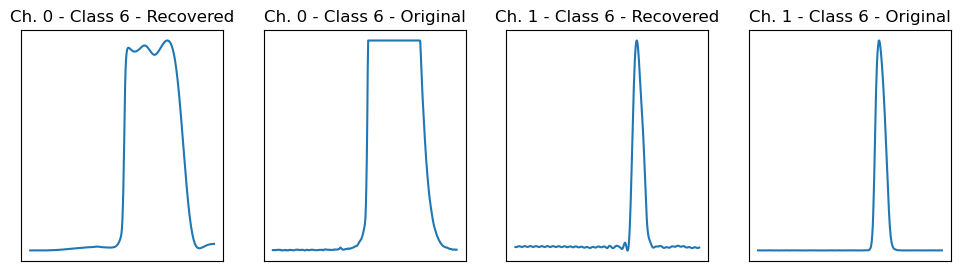

In [26]:
# Visualize randomly selected signals from each class and show their reconstructions
import random
import matplotlib.pyplot as plt

for class_label in range(1, 7):
    class_indices = [i for i, label in enumerate(Y_train) if label == class_label]

    random_index = random.choice(class_indices)

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
    axes[0].plot(Ch0_recovered[random_index, :])
    axes[0].set_title(f"Ch. 0 - Class {class_label} - Recovered")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].plot(X_train[random_index, :,0])
    axes[1].set_title(f"Ch. 0 - Class {class_label} - Original")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[2].plot(Ch1_recovered[random_index, :])
    axes[2].set_title(f"Ch. 1 - Class {class_label} - Recovered")
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[3].plot(X_train[random_index, :,1])
    axes[3].set_title(f"Ch. 1 - Class {class_label} - Original")
    axes[3].set_xticks([])
    axes[3].set_yticks([])
    plt.show()

## Compare PCA Components to incandescent max. vs. color ratio space

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.colors import ListedColormap

target_names = ["FS", "FS+glyc", "CFA", "ATD", "VA", "$Fe_{2}O_{3}$", "$Fe_{3}O_{4}$"]
cmap1 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])

/var/folders/n1/j9r40q610fjg5jmq47vnbz2m0000gn/T/ipykernel_8992/3550557953.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(target_names)


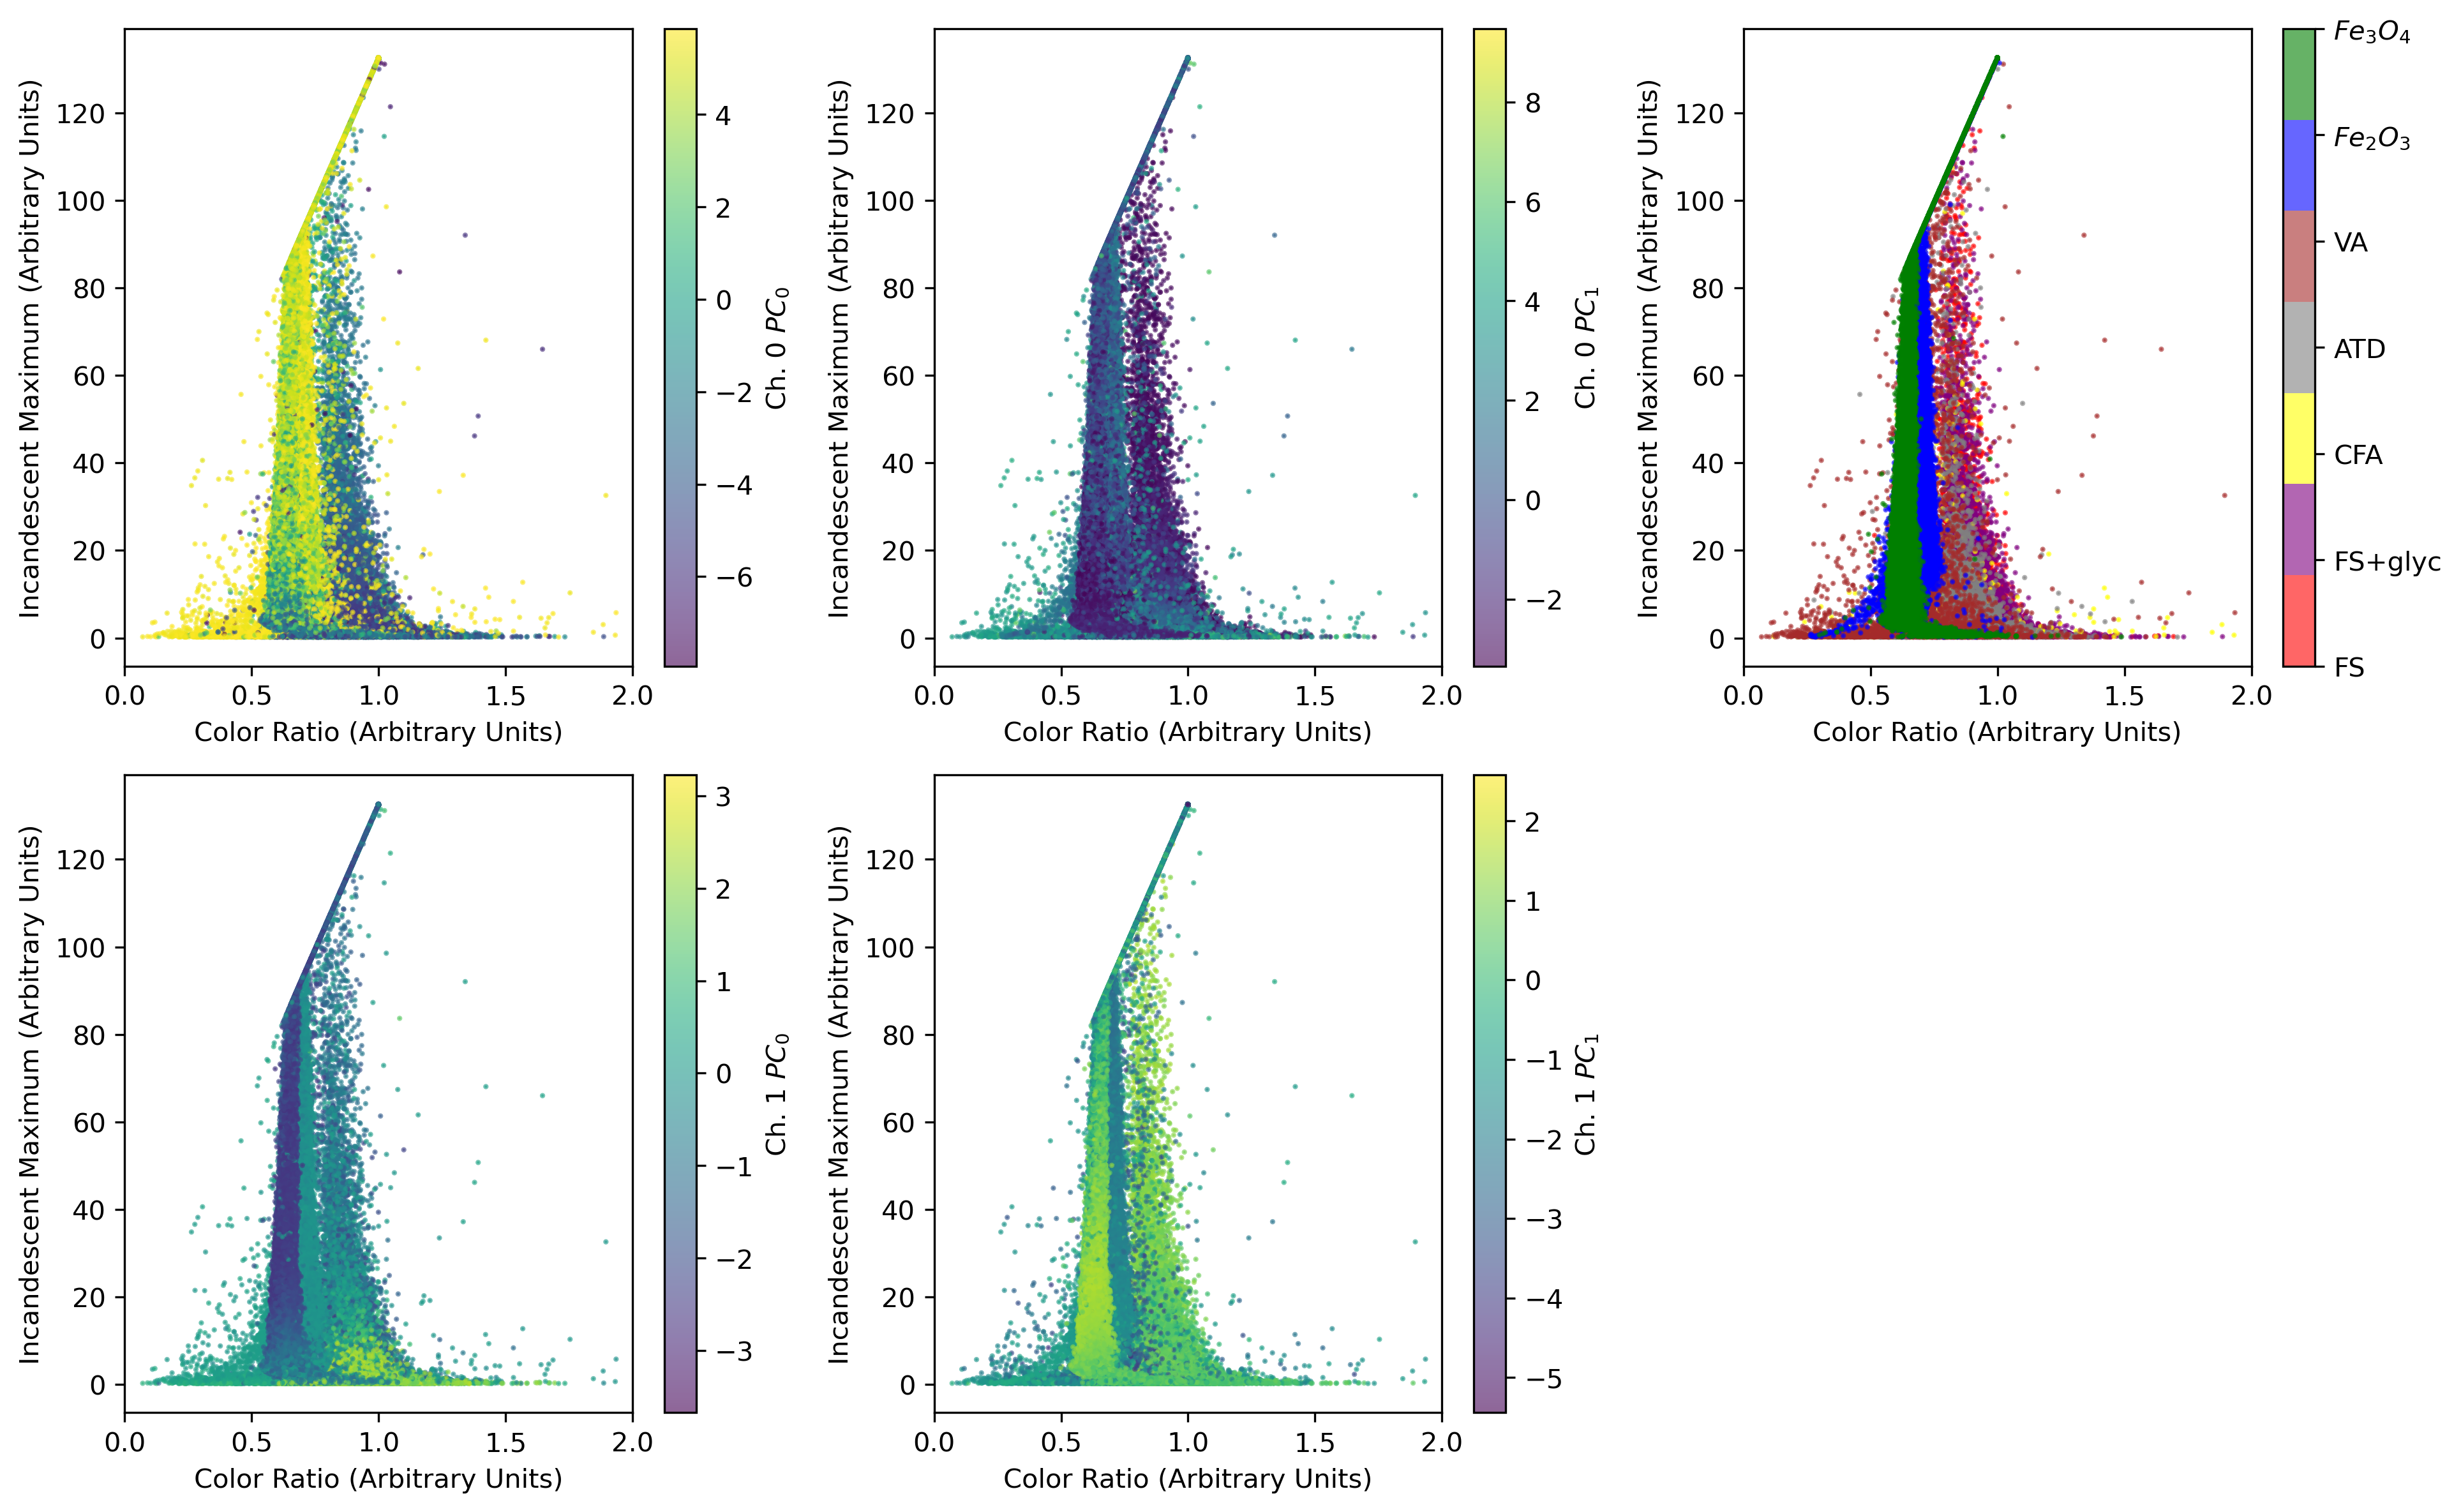

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,3, figsize=(13, 8), dpi=300)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

z_labels = ['Ch. 0 $PC_0$', 'Ch. 0 $PC_1$', 'Ch. 1 $PC_0$', 'Ch. 1 $PC_1$']

axes = axes.flatten()

for i in range(2):
    sc = axes[i].scatter(
        color_channel_ratio,
        channel_max_X_train[:,1],
        c=Ch0_reduced[:,i],
        s=1,
        cmap='viridis',
        alpha=0.6
    )
    axes[i].set_xlim(0, 2)
    axes[i].set_xlabel("Color Ratio (Arbitrary Units)")
    axes[i].set_ylabel("Incandescent Maximum (Arbitrary Units)")
    cbar = fig.colorbar(sc, ax=axes[i])
    cbar.set_label(z_labels[i])
    # axes[i].set_title(f"Scatter Plot Colored by {z_labels[i]}")


sc = axes[2].scatter(
    color_channel_ratio,
    channel_max_X_train[:,1],
    c=Y_train_filtered,
    s=1,
    cmap=cmap1,
    alpha=0.6
)
axes[2].set_xlim(0, 2)
axes[2].set_xlabel("Color Ratio (Arbitrary Units)")
axes[2].set_ylabel("Incandescent Maximum (Arbitrary Units)")
cbar = fig.colorbar(sc, ax=axes[2])
cbar.set_ticklabels(target_names)

for i in range(2):
    sc = axes[3+i].scatter(
        color_channel_ratio,
        channel_max_X_train[:,1],
        c=Ch1_reduced[:,i],
        s=1,
        cmap='viridis',
        alpha=0.6
    )
    axes[3+i].set_xlim(0, 2)
    axes[3+i].set_xlabel("Color Ratio (Arbitrary Units)")
    axes[3+i].set_ylabel("Incandescent Maximum (Arbitrary Units)")
    cbar = fig.colorbar(sc, ax=axes[3+i])
    cbar.set_label(z_labels[2+i])
    # axes[i].set_title(f"Scatter Plot Colored by {z_labels[i]}")

axes[5].remove()

plt.tight_layout()
plt.savefig("Inc_Vs_Color_PCA.png", dpi=300)
plt.show()

## PCA Component Visualization by Aerosol Class

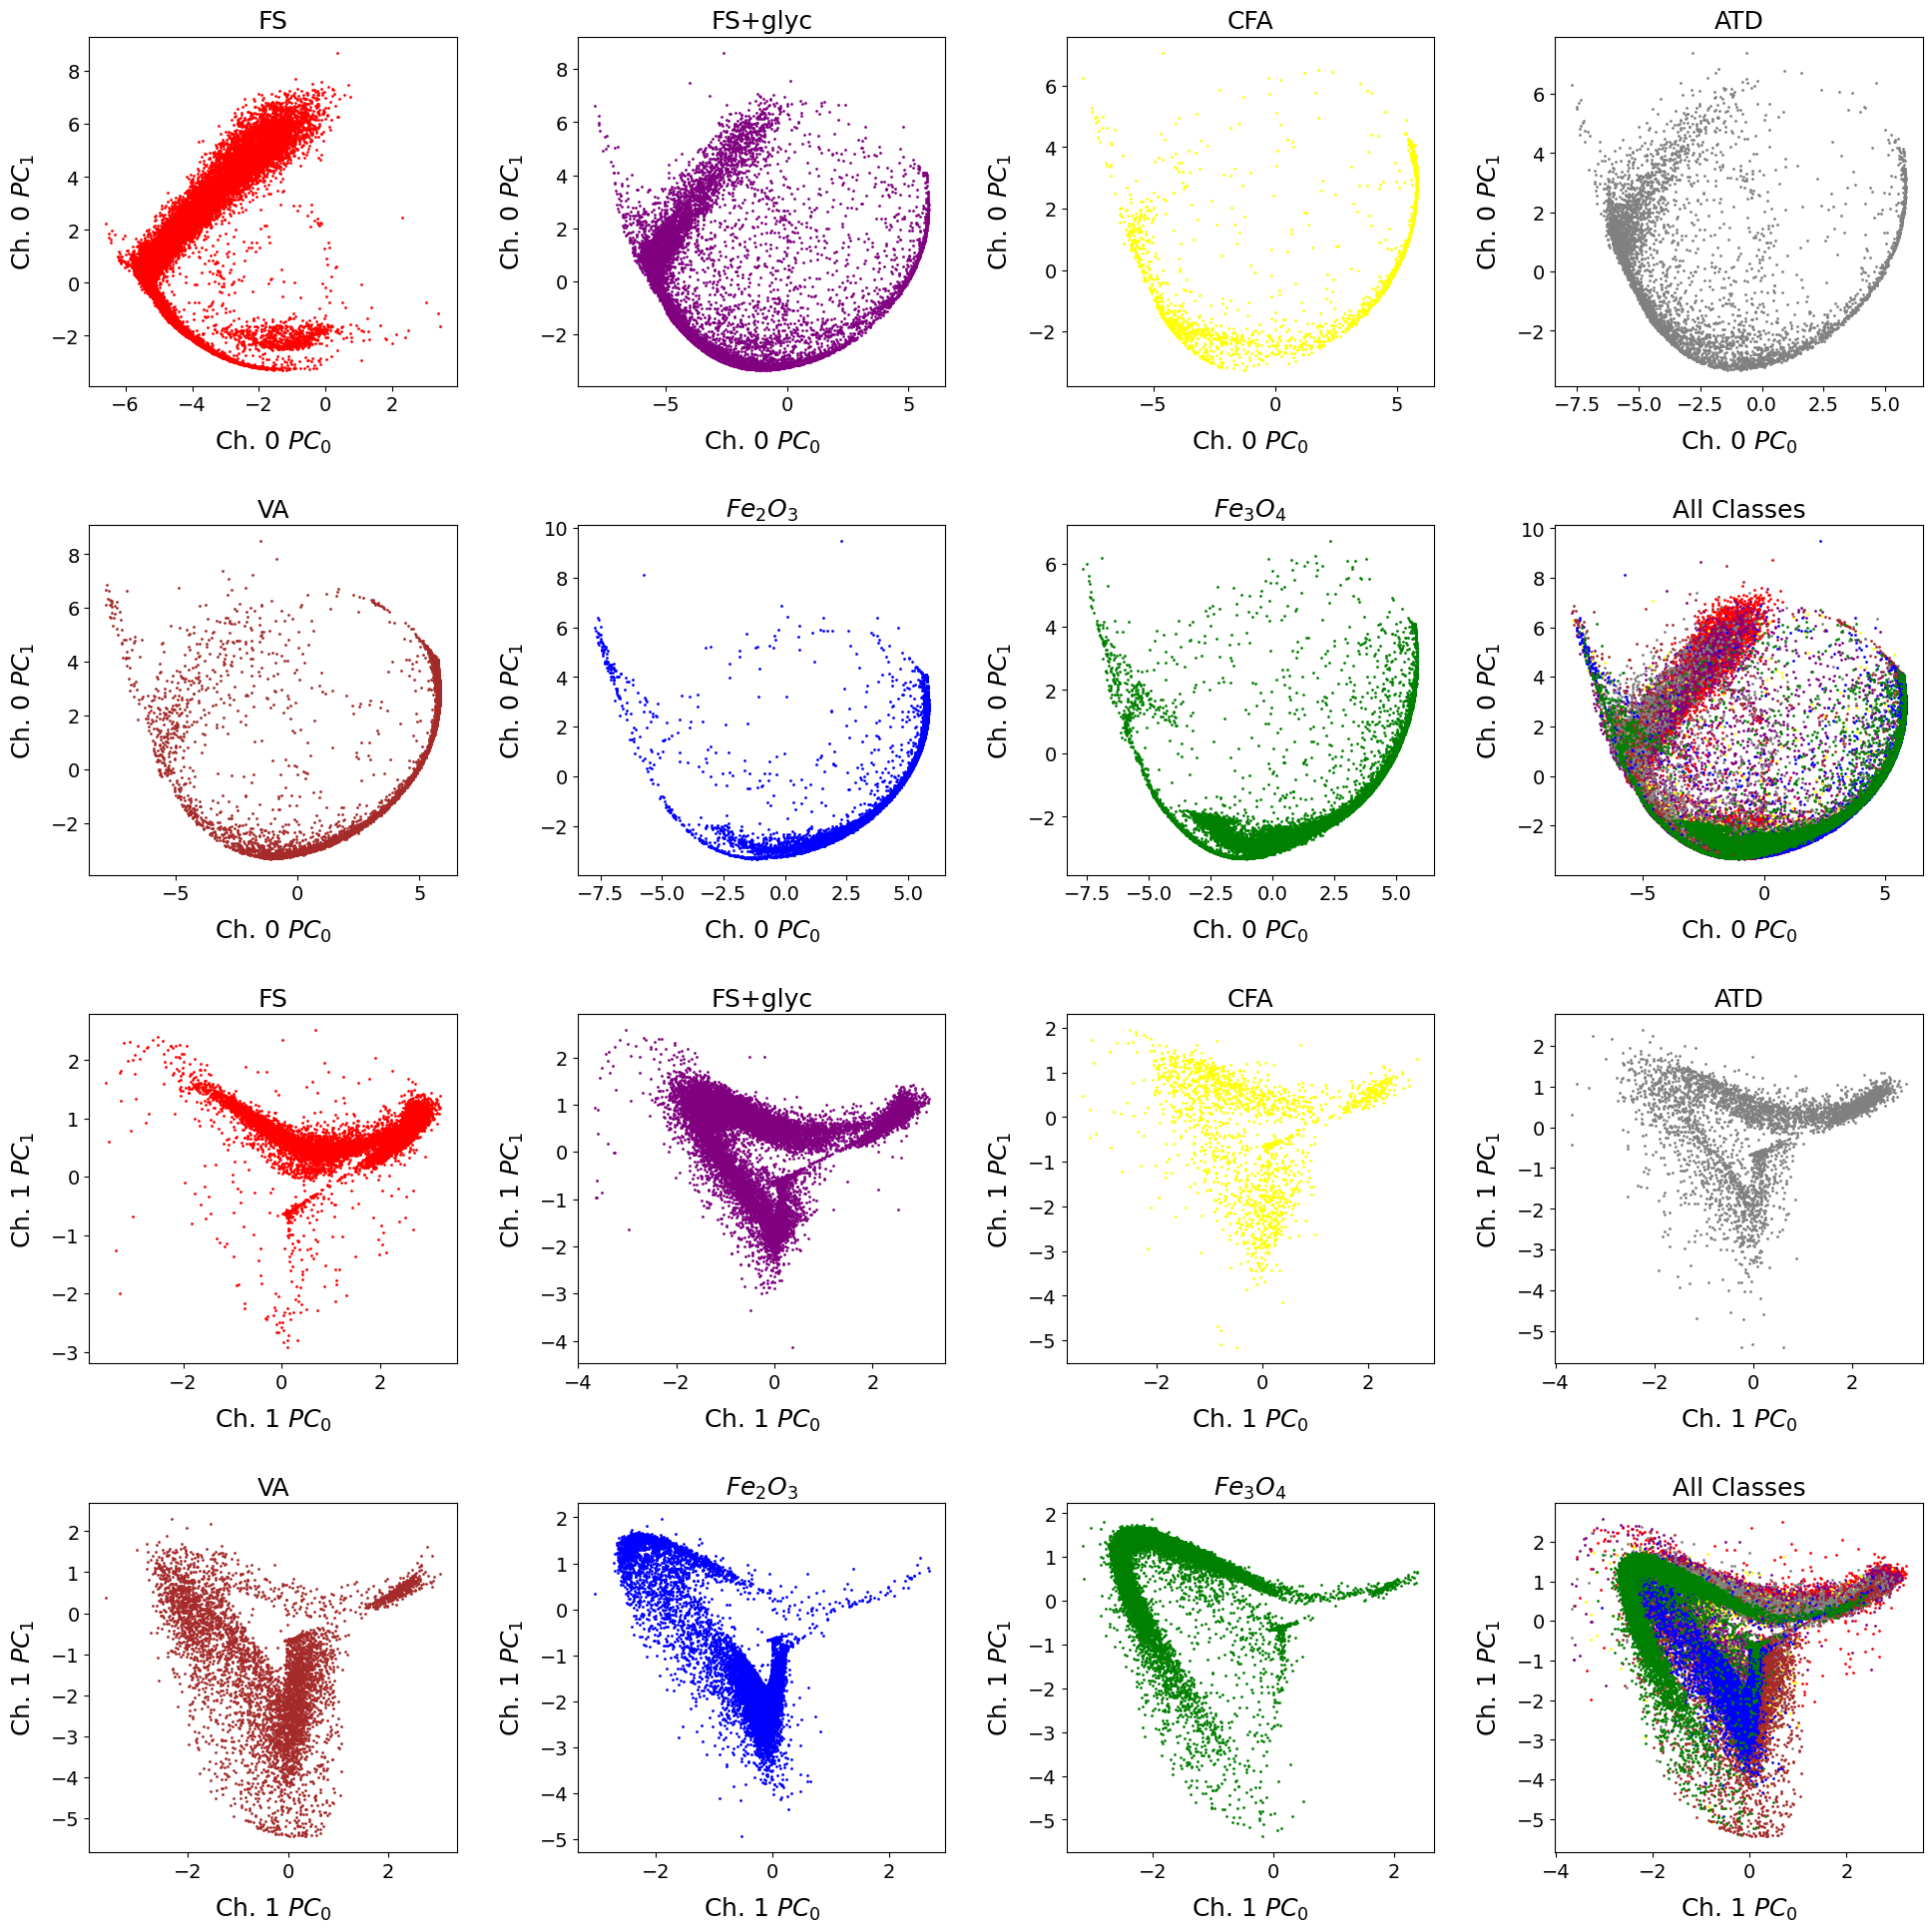

In [29]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for idx_0 in range(7):
    class_indices = np.where(Y_train == idx_0)
    z_mean_class = Ch0_reduced[class_indices[0],:]
    ax = axs[idx_0 // 4, idx_0 % 4]
    ax.scatter(z_mean_class[:, 0], z_mean_class[:, 1], s=1, color=cmap1(idx_0), label=target_names[idx_0])
    ax.set_xlabel("Ch. 0 $PC_0$", fontsize=18, labelpad=10)
    ax.set_ylabel("Ch. 0 $PC_1$", fontsize=18, labelpad=10)
    #ax.legend(fontsize=11, loc='upper left')
    ax.set_title(target_names[idx_0], fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)

ax_all = axs[1, 3]
for idx_0 in range(7):
    class_indices = np.where(Y_train == idx_0)
    z_mean_class = Ch0_reduced[class_indices[0],:]
    ax_all.scatter(z_mean_class[:, 0], z_mean_class[:, 1], s=1, color=cmap1(idx_0), label=target_names[idx_0])

ax_all.set_xlabel("Ch. 0 $PC_0$", fontsize=18, labelpad=10)
ax_all.set_ylabel("Ch. 0 $PC_1$", fontsize=18, labelpad=10)
#ax_all.legend(fontsize=11, loc='upper left')
ax_all.set_title("All Classes", fontsize=18)
ax_all.tick_params(axis='both', which='major', labelsize=14)
ax_all.tick_params(axis='both', which='minor', labelsize=12)

for idx_1 in range(7):
    class_indices = np.where(Y_train == idx_1)
    z_mean_class = Ch1_reduced[class_indices[0],:]

    ax = axs[idx_1 // 4+2, idx_1 % 4]
    ax.scatter(z_mean_class[:, 0], z_mean_class[:, 1], s=1, color=cmap1(idx_1), label=target_names[idx_1])
    ax.set_xlabel("Ch. 1 $PC_0$", fontsize=18, labelpad=10)
    ax.set_ylabel("Ch. 1 $PC_1$", fontsize=18, labelpad=10)
    #ax.legend(fontsize=11, loc='upper left')
    ax.set_title(target_names[idx_1], fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.grid(False)

# For the combined plot
ax_all = axs[3, 3]
for idx_1 in range(7):
    class_indices = np.where(Y_train == idx_1)
    z_mean_class = Ch1_reduced[class_indices[0],:]
    ax_all.scatter(z_mean_class[:, 0], z_mean_class[:, 1], s=1, color=cmap1(idx_1), label=target_names[idx_1])

ax_all.set_xlabel("Ch. 1 $PC_0$", fontsize=18, labelpad=10)
ax_all.set_ylabel("Ch. 1 $PC_1$", fontsize=18, labelpad=10)
#ax_all.legend(fontsize=11, loc='upper left')
ax_all.tick_params(axis='both', which='major', labelsize=14)
ax_all.tick_params(axis='both', which='minor', labelsize=12)
ax_all.set_title("All Classes", fontsize=18)
ax.grid(False)


plt.tight_layout(pad=3.0)
filename = 'PCAComponent_AerosolClass.png'
plt.savefig(filename, dpi=300)
plt.show()

## Calculate cosine similarity metric

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
PCs = np.hstack((Ch0_reduced,Ch1_reduced))
PCs.shape

(85832, 29)

In [32]:
def calculate_cos_sim(embeddings,class_labels):
  n_classes = len(np.unique(class_labels))

  class_cos_sims = np.zeros((n_classes,n_classes))
  for i in range(0,n_classes):
      for j in range(0,n_classes):
          classA_indices = np.where(class_labels == i)
          classB_indices = np.where(class_labels == j)
          pc_classA = embeddings[classA_indices[0],:]
          pc_classB = embeddings[classB_indices[0],:]
          pairwise_similarities = cosine_similarity(pc_classA,pc_classB)
          class_cos_sims[i,j] = np.mean(pairwise_similarities)
  return class_cos_sims

In [33]:
cos_sims_Ch0 = calculate_cos_sim(Ch0_reduced,Y_train)
cos_sims_Ch1 = calculate_cos_sim(Ch1_reduced,Y_train)

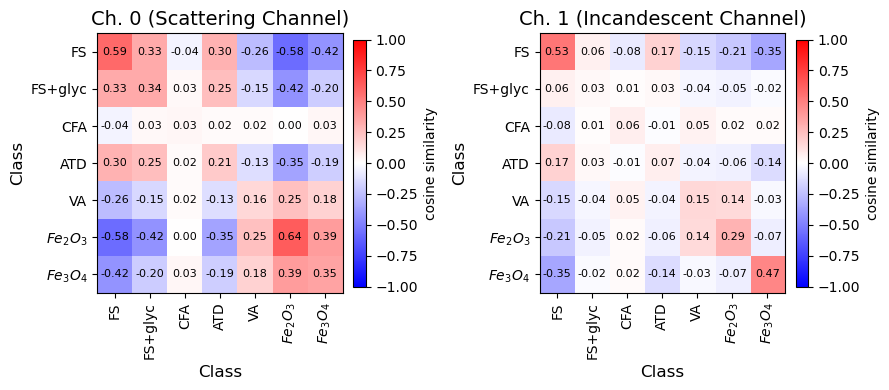

In [34]:
fig, axs = plt.subplots(1,2,figsize=(9, 4))
cos_sims = [cos_sims_Ch0,cos_sims_Ch1]
names = ["Ch. 0 (Scattering Channel)","Ch. 1 (Incandescent Channel)"]

for k in range(0,2):
    ax = axs[k]
    im = ax.imshow(cos_sims[k], aspect='auto', origin='upper',vmin=-1,vmax=1,cmap="bwr")
    ax.set_title(names[k], fontsize=14)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Class', fontsize=12)
    
    ax.set_xticks(range(len(target_names)))
    ax.set_xticklabels(target_names, rotation=90)
    ax.set_yticks(range(len(target_names)))
    ax.set_yticklabels(target_names)
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label("cosine similarity")

    for i in range(cos_sims[k].shape[0]):
        for j in range(cos_sims[k].shape[0]):
            val = cos_sims[k][i, j]
            text = "{:.2f}".format(val) 
            ax.text(j, i, text, ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.savefig("CosineSimilarity_PCA.png",dpi=300)

## Random Forest Analysis

In [35]:
# get rid of outliers
color_channel_ratio[color_channel_ratio>2] = 1
color_channel_ratio_val[color_channel_ratio_val>2] = 1
color_channel_ratio_test[color_channel_ratio_test>2] = 1
count = np.sum(color_channel_ratio > 2)
count

0

In [49]:
pca_ch0_val = PCA(n_components=0.95)
Ch0_reduced_val = pca_ch0_val.fit_transform(X_val[:,:,0])
pca_ch1_val = PCA(n_components=0.95)
Ch1_reduced_val = pca_ch1_val.fit_transform(X_val[:,:,1])

pca_ch0_test = PCA(n_components=0.95)
Ch0_reduced_test = pca_ch0_test.fit_transform(X_test[:,:,0])
pca_ch1_test = PCA(n_components=0.95)
Ch1_reduced_test = pca_ch1_test.fit_transform(X_test[:,:,1])

In [50]:
Ch0_reduced[:,0:2].shape

(85832, 2)

In [51]:
z_all = np.hstack((Ch0_reduced[:,0:2],Ch1_reduced[:,0:2]))
z_all = np.hstack((z_all,color_channel_ratio.reshape(-1, 1),channel_max_X_train[:,0:2]))

zval_all = np.hstack((Ch0_reduced_val[:,0:2],Ch1_reduced_val[:,0:2]))
zval_all = np.hstack((zval_all,color_channel_ratio_val.reshape(-1, 1),channel_max_X_val[:,0:2]))

ztest_all = np.hstack((Ch0_reduced_test[:,0:2],Ch1_reduced_test[:,0:2]))
ztest_all = np.hstack((ztest_all,color_channel_ratio_test.reshape(-1, 1),channel_max_X_test[:,0:2]))

In [52]:
from sklearn.preprocessing import StandardScaler, normalize

In [53]:
scaler = StandardScaler()
x_all = scaler.fit_transform(z_all)
xval_all = scaler.transform(zval_all)
xtest_all = scaler.transform(ztest_all)

In [54]:
pd.DataFrame(x_all).describe()

,0,1,2,3,4,5,6
count,8.583200e+04,8.583200e+04,8.583200e+04,8.583200e+04,8.583200e+04,8.583200e+04,8.583200e+04
mean,-2.490112e-15,-1.626520e-15,-3.560330e-15,3.994775e-15,8.981952e-18,-2.435541e-14,1.650361e-15
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-1.911394e+00,-1.435022e+00,-2.162647e+00,-4.172351e+00,-3.413327e-03,-1.629941e+00,-7.678647e-01
25%,-9.883519e-01,-8.415918e-01,-8.132320e-01,-9.001945e-01,-3.413327e-03,-1.272180e+00,-6.957786e-01
50%,-1.646525e-01,-1.034219e-01,-7.096240e-02,4.513320e-01,-3.413327e-03,7.039501e-01,-3.768585e-01
75%,1.068884e+00,6.183195e-01,1.118076e+00,6.918500e-01,-3.413327e-03,7.236437e-01,3.023881e-01
max,1.409957e+00,4.062808e+00,1.899493e+00,1.975660e+00,2.929693e+02,1.074370e+00,3.988303e+00


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

rf = RandomForestClassifier()
rf.fit(x_all, Y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [56]:
y_output = rf.predict(xval_all)

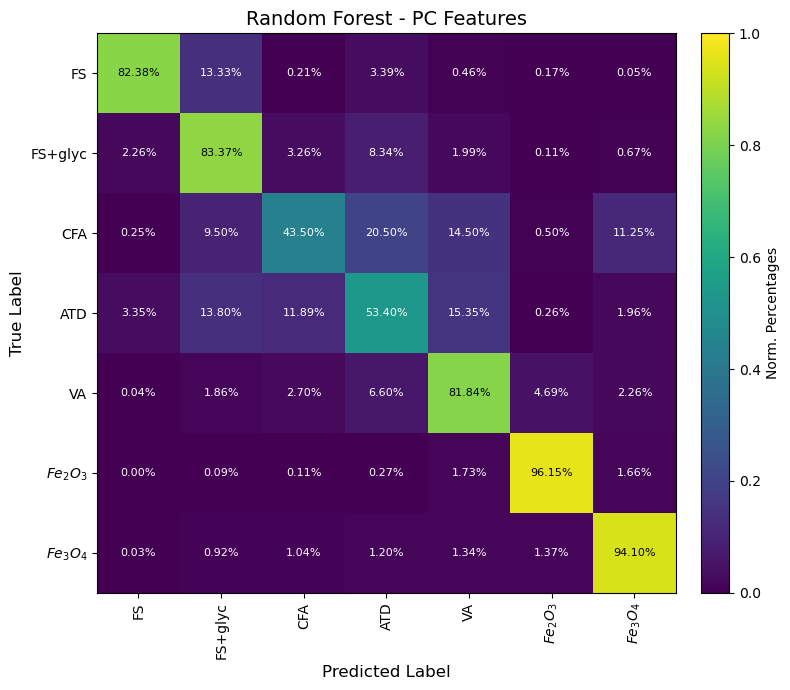

In [57]:
fig, ax = plt.subplots(figsize=(8, 7))

correlation_arr = confusion_matrix(y_output, Y_val, normalize='true')

im = ax.imshow(correlation_arr, aspect='auto', origin='upper',vmin=0,vmax=1,cmap="viridis")
ax.set_title("Random Forest - PC Features", fontsize=14)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)

ax.set_xticks(range(len(target_names)))
ax.set_xticklabels(target_names, rotation=90)
ax.set_yticks(range(len(target_names)))
ax.set_yticklabels(target_names)
# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Norm. Percentages")

for i in range(correlation_arr.shape[0]):
    for j in range(correlation_arr.shape[0]):
        val = correlation_arr[i, j]
        text = "{:.2%}".format(val)
        if val>0.75:
          ax.text(j, i, text, ha='center', va='center', fontsize=8,color='black')
        else:
          ax.text(j, i, text, ha='center', va='center', fontsize=8,color='white')
plt.tight_layout()
plt.savefig('confusion_matrix_high_res_PCA.png', dpi=300)